In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
import os
def get_strategy():
  if 'COLAB_TPU_ADDR' in os.environ: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('train with TPU ', tpu.cluster_spec().as_dict()['worker'])
  else:
    strategy = tf.distribute.MirroredStrategy() 
    if tf.test.gpu_device_name()!='': 
      print('train with ',tf.test.gpu_device_name()) 
    else:
      print('train with CPU') 
  return strategy 

In [4]:
strategy=get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.26.149.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.26.149.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


train with TPU  ['10.26.149.10:8470']


# 1.資料預處理

In [5]:
#1.資料預處理mnist CNN

In [6]:
from keras.utils import np_utils
import numpy as np
np.random.seed(10)

In [7]:
from keras.datasets import mnist
(x_train_image,y_train_label),\
(x_test_image,y_test_label)= mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
x_train_image_4d=x_train_image.reshape(-1,28,28,1).astype('float32')
x_test_image_4d=x_test_image.reshape(-1,28,28,1).astype('float32')

In [9]:
x_train_normalize = x_train_image_4d / 255
x_test_normalize = x_test_image_4d / 255 

In [10]:
y_train_onehot = np_utils.to_categorical(y_train_label)
y_test_onehot = np_utils.to_categorical(y_test_label)

In [11]:
print('Train:',x_train_normalize.shape)
print('Test:',x_test_normalize.shape)

Train: (60000, 28, 28, 1)
Test: (10000, 28, 28, 1)


In [12]:
print('Train:',y_train_onehot.shape)
print('Test:',y_test_onehot.shape)

Train: (60000, 10)
Test: (10000, 10)


In [13]:
class_names =["0","1","2","3","4","5","6","7","8","9"]

# 建立模型

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

In [15]:
def create_model():
  model = Sequential()
  model.add(Conv2D(
      filters=16,kernel_size=(5,5),padding='same',
      input_shape=(28,28,1),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(
      filters=36,kernel_size=(5,5),
      padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10,activation='softmax'))
  return model

# 訓練模型

In [16]:
with strategy.scope():
  model = create_model()
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 36)        14436     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 36)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1764)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [18]:
train_history=model.fit(
    x=x_train_normalize,
    y=y_train_onehot,
    validation_split=0.2,
    batch_size=200,
    epochs=10,
    verbose=2)

Epoch 1/10
240/240 - 10s - loss: 0.2947 - acc: 0.9183 - val_loss: 0.1012 - val_acc: 0.9692 - 10s/epoch - 43ms/step
Epoch 2/10
240/240 - 4s - loss: 0.0753 - acc: 0.9770 - val_loss: 0.0650 - val_acc: 0.9803 - 4s/epoch - 18ms/step
Epoch 3/10
240/240 - 2s - loss: 0.0518 - acc: 0.9841 - val_loss: 0.0573 - val_acc: 0.9821 - 2s/epoch - 10ms/step
Epoch 4/10
240/240 - 2s - loss: 0.0377 - acc: 0.9885 - val_loss: 0.0504 - val_acc: 0.9859 - 2s/epoch - 10ms/step
Epoch 5/10
240/240 - 2s - loss: 0.0303 - acc: 0.9909 - val_loss: 0.0408 - val_acc: 0.9883 - 2s/epoch - 10ms/step
Epoch 6/10
240/240 - 2s - loss: 0.0244 - acc: 0.9924 - val_loss: 0.0415 - val_acc: 0.9887 - 2s/epoch - 10ms/step
Epoch 7/10
240/240 - 2s - loss: 0.0221 - acc: 0.9930 - val_loss: 0.0393 - val_acc: 0.9892 - 2s/epoch - 10ms/step
Epoch 8/10
240/240 - 2s - loss: 0.0165 - acc: 0.9948 - val_loss: 0.0358 - val_acc: 0.9898 - 2s/epoch - 10ms/step
Epoch 9/10
240/240 - 2s - loss: 0.0133 - acc: 0.9958 - val_loss: 0.0415 - val_acc: 0.9879 - 2s

In [19]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_key,valid_key):
    plt.plot(train_history.history[train_key],'--')
    plt.plot(train_history.history[valid_key])
    plt.title('Train History')
    plt.ylabel(train_key)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

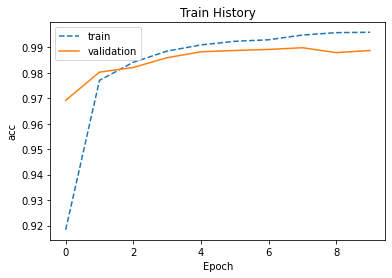

In [20]:
show_train_history(train_history,'acc','val_acc')

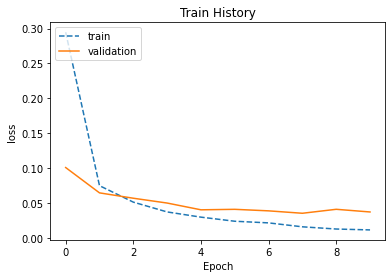

In [21]:
show_train_history(train_history,'loss','val_loss') 

# 評估模型準確率

In [22]:
#4.評估模型準確率

In [23]:
scores=model.evaluate(x_test_normalize, y_test_onehot,verbose=2)

313/313 - 6s - loss: 0.0320 - acc: 0.9900 - 6s/epoch - 19ms/step


In [24]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.03203645721077919 test_acc= 0.9899999499320984


# 預測結果

In [25]:
#5.進行預測

In [26]:
probability = model.predict(x_test_normalize)

In [27]:
prediction=tf.argmax(probability, axis=-1).numpy() 

In [28]:
prediction

array([7, 2, 1, ..., 4, 5, 6])

In [29]:
def show_predicted_probability(
    images,labels,prediction,probability,idx):
  plt.figure(figsize=(1,1));
  plt.xticks([]);plt.yticks([])
  plt.imshow(images[idx],cmap='binary')
  plt.show()
  print('label:',labels[idx],
     'predict:',prediction[idx]) 
  for i in range(10):
    print(i,' Probability:%.9f'%(probability[idx][i]))  

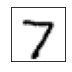

label: 7 predict: 7
0  Probability:0.000000000
1  Probability:0.000000001
2  Probability:0.000000000
3  Probability:0.000000334
4  Probability:0.000000000
5  Probability:0.000000000
6  Probability:0.000000000
7  Probability:0.999999642
8  Probability:0.000000000
9  Probability:0.000000024


In [30]:
show_predicted_probability(x_test_image,y_test_label,prediction,probability,0)

# 查看預測結果

In [31]:
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')

        ax.set_title("label=" +str(labels[idx])+
               ",predict="+str(prediction[idx])
               ,fontsize=10) 
        
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

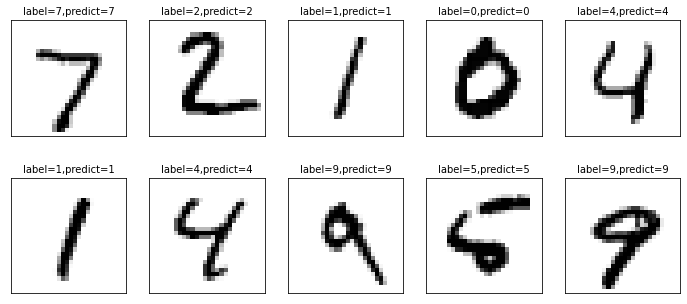

In [32]:
plot_images_labels_prediction(x_test_image,y_test_label,prediction,idx=0)

# confusion matrix

In [33]:
import pandas as pd

cm=pd.crosstab(y_test_label,prediction,rownames=['label'],colnames=['predict'])

In [34]:
cm

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,978,0,0,0,0,0,0,2,0,0
1,0,1130,2,0,0,0,1,2,0,0
2,0,2,1018,1,1,0,0,9,1,0
3,0,0,0,1007,0,3,0,0,0,0
4,0,0,0,0,980,0,0,1,0,1
5,1,0,0,5,0,883,1,0,0,2
6,5,2,1,0,5,8,935,0,2,0
7,0,1,0,0,0,0,0,1026,1,0
8,2,0,3,3,0,4,0,2,956,4


In [35]:
df = pd.DataFrame({'label':y_test_label,'predict':prediction})

In [36]:
df[(df.label==5)&(df.predict==3)]

,label,predict
340,5,3
1393,5,3
2369,5,3
2597,5,3
5937,5,3


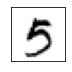

label: 5 predict: 5
0  Probability:0.000000000
1  Probability:0.000000000
2  Probability:0.000000000
3  Probability:0.004768710
4  Probability:0.000000000
5  Probability:0.995044470
6  Probability:0.000000000
7  Probability:0.000000006
8  Probability:0.000000066
9  Probability:0.000186713


In [37]:
show_predicted_probability(x_test_image,y_test_label,prediction,probability,4355)